# LightGBM

In [59]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


In [60]:
df_train=pd.read_json(open(r"train.json"))

In [61]:
#print(df_train.shape)

In [62]:
df_train["num_photos"]=df_train["photos"].apply(len)
df_train["num_features"]=df_train["features"].apply(len)
df_train["num_description_words"]=df_train["description"].apply(lambda x:len(x.split(" "))) #根據空白切割，去算字數
def caculate(n_words):
    description_test=[]
    for i in n_words:
        description_test.append(len(i.split(" ")))
    return description_test #效果和上面一樣
df_train["created"]=pd.to_datetime(df_train["created"])
df_train["created_year"]=df_train["created"].dt.year
df_train["created_month"] = df_train["created"].dt.month
df_train["created_day"] = df_train["created"].dt.day

In [63]:
df_train["n_description_words"]=caculate(df_train["description"])

In [64]:
#print(df_train.shape)

In [65]:
high = df_train[df_train["interest_level"] == 'high']
medium = df_train[df_train["interest_level"] == 'medium']
low = df_train[df_train["interest_level"] == 'low']
#print(len(high),len(medium),len(low))

High: 3839
Medium: 11229
Low: 34284


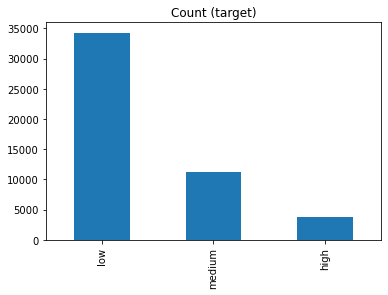

In [66]:
import matplotlib.pyplot as plt
target_count = df_train.interest_level.value_counts()
print('High:', target_count['high'])
print('Medium:', target_count['medium'])
print('Low:', target_count['low'])

target_count.plot(kind='bar', title='Count (target)');

## Over Sampling

In [67]:
df_high = high.sample(len(low),replace=True)
df_med = medium.sample(len(low),replace=True)


## Concatation and Shuffle

In [68]:
df_train = pd.concat([df_high,df_med,low],axis = 0)
df_train = df_train.sample(frac=1)
#len(df_train)

High: 34284
Medium: 34284
Low: 34284


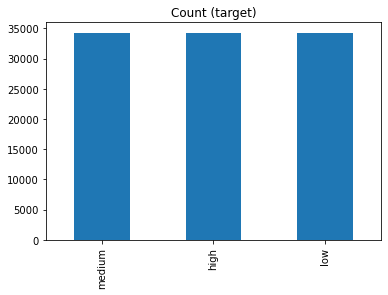

In [69]:
target_count = df_train.interest_level.value_counts()
print('High:', target_count['high'])
print('Medium:', target_count['medium'])
print('Low:', target_count['low'])

target_count.plot(kind='bar', title='Count (target)');

In [70]:
choose_columns=["bathrooms", "bedrooms", "latitude", "longitude", "price","num_photos", "num_features","num_description_words","created_year", "created_month", "created_day"]

In [71]:
X=df_train[choose_columns]
Y=df_train["interest_level"]

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

In [73]:
#LightGBM
import lightgbm as lgb
clf = lgb.LGBMClassifier(n_estimators=1000,min_data_in_leaf=300)
clf.fit(X_train, Y_train)


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=300, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## feature selection

In [74]:
# Print the name and gini importance of each feature
from sklearn.feature_selection import SelectFromModel
for feature in zip(choose_columns, clf.feature_importances_):
    print(feature)

('bathrooms', 872)
('bedrooms', 2775)
('latitude', 14553)
('longitude', 14972)
('price', 14951)
('num_photos', 5895)
('num_features', 6702)
('num_description_words', 16502)
('created_year', 0)
('created_month', 2762)
('created_day', 10016)


In [75]:
fs = SelectFromModel(clf, threshold=5000)
fs.fit(X_train, Y_train)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=1.0,
                                         importance_type='split',
                                         learning_rate=0.1, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=0.001,
                                         min_data_in_leaf=300,
                                         min_split_gain=0.0, n_estimators=1000,
                                         n_jobs=-1, num_leaves=31,
                                         objective=None, random_state=None,
                                         reg_alpha=0.0, reg_lambda=0.0,
                                         silent=True, subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_f

In [76]:
X_important_train = fs.transform(X_train)
X_important_test = fs.transform(X_test)

In [77]:
# Create a new LGBM classifier for the most important features
clf_important = lgb.LGBMClassifier(n_estimators=1000,min_data_in_leaf=300)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=300, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [78]:
# Apply The Full Featured Classifier To The Test Data
from sklearn.metrics import accuracy_score
Y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print("Accuracy Without Feature Selection: ",accuracy_score(Y_test, Y_pred))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)
# View The Accuracy Of Our Limited Feature (2 Features) Model
print("Accuracy With Feature Selection: : ",accuracy_score(Y_test, y_important_pred))

Accuracy Without Feature Selection:  0.8428856156725487
Accuracy With Feature Selection: :  0.8073987652520539


## Original Classifier (Without FS)

In [79]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Y_pred,Y_test )
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test,Y_pred )))

LightGBM Model accuracy score: 0.8429


# 匯入test data

In [92]:
df_test = pd.read_json(open(r"test.json"))
#print(df_test.shape)
df_test["num_photos"] = df_test["photos"].apply(len)
df_test["num_features"] = df_test["features"].apply(len)
df_test["num_description_words"] = df_test["description"].apply(lambda x: len(x.split(" ")))
df_test["created"] = pd.to_datetime(df_test["created"])
df_test["created_year"] = df_test["created"].dt.year
df_test["created_month"] = df_test["created"].dt.month
df_test["created_day"] = df_test["created"].dt.day

x_test = df_test[choose_columns]
y_pred_test=clf.predict(x_test)#根據X_test預測該房屋有多少機率位於high low medium三個類別
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(Y_train, y_pred_train)))

Training-set accuracy score: 0.9022


## Check for Overfitting

In [83]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, Y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, Y_test)))

Training set score: 0.9022
Test set score: 0.8429


## Confusion Matrix Without Feature Selection

In [84]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion matrix\n\n', cm)


Confusion matrix

 [[6640   57  164]
 [ 302 5199 1337]
 [ 499  873 5500]]


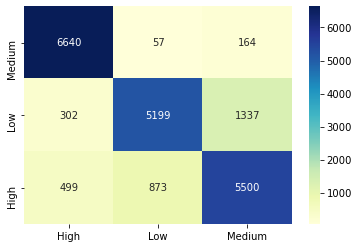

In [85]:
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['High', 'Low','Medium'], 
                                 index=['Medium', 'Low','High'])


sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Confusion Matrix With FS

Confusion matrix

 [[6474  114  273]
 [ 410 4868 1560]
 [ 582 1023 5267]]


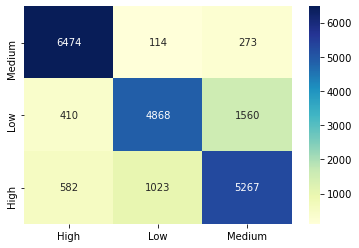

In [86]:
cm = confusion_matrix(Y_test, y_important_pred)
print('Confusion matrix\n\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['High', 'Low','Medium'], 
                                 index=['Medium', 'Low','High'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Classification Matrix Without FS

In [87]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

        high       0.89      0.97      0.93      6861
         low       0.85      0.76      0.80      6838
      medium       0.79      0.80      0.79      6872

    accuracy                           0.84     20571
   macro avg       0.84      0.84      0.84     20571
weighted avg       0.84      0.84      0.84     20571



## Classification Matrix Without FS

In [89]:
print(classification_report(Y_test, y_important_pred))

              precision    recall  f1-score   support

        high       0.87      0.94      0.90      6861
         low       0.81      0.71      0.76      6838
      medium       0.74      0.77      0.75      6872

    accuracy                           0.81     20571
   macro avg       0.81      0.81      0.81     20571
weighted avg       0.81      0.81      0.81     20571

